In [1]:
# Update PATH environment variable
import os
os.environ['PATH'] = '/opt/homebrew/bin:' + os.environ['PATH']

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from scipy.optimize import minimize

from fppanalysis.running_moments import window_radius, run_norm_ds
from fppanalysis import conditional_averaging

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_rz

from analysis_functions.exp_fit_functions import (
    exp_fit_function,
    shot_fit_range,
    rise_time,
    decay_time,
    bi_exp_decay,
    bi_exp_fit_function,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def find_closest_value(arr, val):
    """ Find closest value in Numpy array to a certain value. """
    idx = np.abs(arr - val).argmin()
    return arr[idx]

### This code plots the conditional average waveform and computes the fit to an exponential and bi-exponential rise and decay

In [3]:
shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

$f_{\mathrm{GW}}$ = 0.64$\tau_{df}$ = 4.6$\mu s$ $\tau_{ds}$ = 26.1$\mu s$
$f_{\mathrm{GW}}$ = 0.46$\tau_{df}$ = 4.3$\mu s$ $\tau_{ds}$ = 30.3$\mu s$
$\tau_{rise}$ = 5.1 $\mu \mathrm{s}$


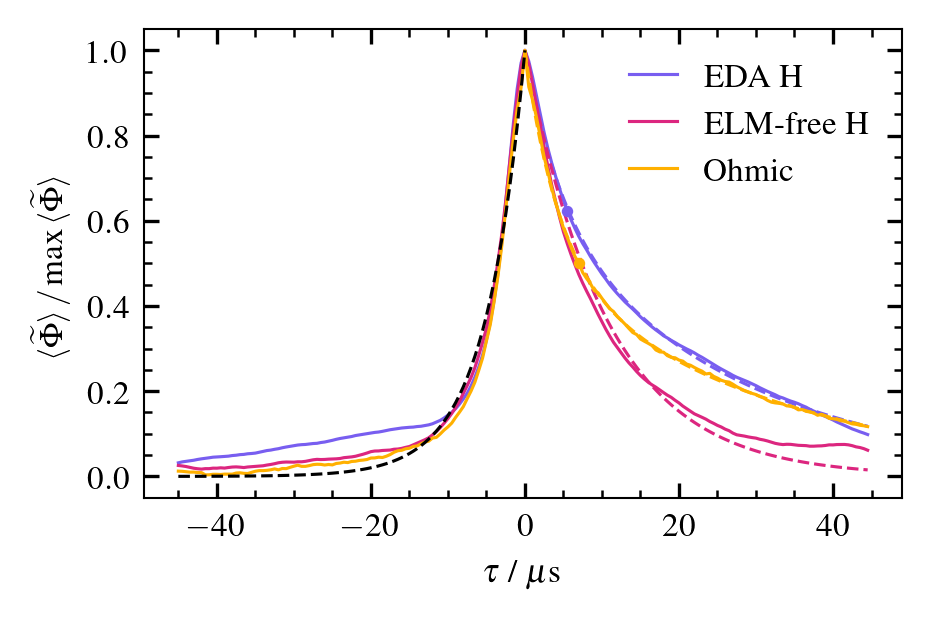

In [9]:
save = True

params = {}
cosmoplots.set_rcparams_dynamo(params, num_cols=1)
plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')


fig, ax = plt.subplots()

x_pixel = 7
y_pixel = 4

average_tau_rise = []
rise_list = []
rise_x_list = []

for idx, shot in enumerate(shotlist):

    f_GW = greenwald_fraction[shot]
    f_GW = '{:0.2f}'.format(f_GW)
    path = Path("/Users/ahe104/Box/mfe_data/raw_apd_data/")
    ds = xr.open_dataset(str(path) + "/" + f"apd_signal_array_{shot}.nc")

    # Remove dead pixels
    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(
        str(path_dead_pixel)
        + "/"
        + f"dead_pixels_shot_{shot}.npz"
    )
    dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan

    # Specify time window for shot
    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    sliced_ds = ds.sel(time=slice(t_start, t_end))

    # Run normalization, first create a running window of 1 ms.
    radius = window_radius(1e3, sliced_ds.time)
    ds = run_norm_ds(sliced_ds, radius)

    # Get signal and time for a given pixel position
    data = get_signal(x=x_pixel, y=y_pixel, ds=ds)
    time = get_time(x=x_pixel, y=y_pixel, ds=ds)
    R, Z = get_rz(x_pixel, y_pixel, ds)
    R_string = "{:.1f}".format(R)
    Z_string = "{:.1f}".format(Z)

    # Conditional averaging
    Svals, s_av, s_var, t_av, peaks, wait = conditional_averaging.cond_av(
        data, time, 2.5, delta=1.4e-4, window=True, print_verbose=False,
    )

    # Normalize waveform in order to compare to other shots
    norm_s_av = (s_av - min(s_av)) / max(s_av - min(s_av))
    t_av = t_av*1e6 # Convert to microseconds

    # Shorten fit range for far SOL shots to 10 mu seconds
    peak_point = np.where(t_av == 0)[0][0]
    fit_range_decay = shot_fit_range[shot]
    fit_range_rise = 45
    fit_range_decay = 45
    #fit_range = 60

    #---------------- Rise and decay fit ----------------#
    # Find end point of rise
    rise_end = np.where(t_av == find_closest_value(t_av[: peak_point + 1], -fit_range_rise))[0][0]
    rise_x = t_av[rise_end : peak_point + 1]  # Time base of rise
    rise = norm_s_av[rise_end : peak_point + 1] # Rise

    # Find end point of decay
    decay_end = np.where(t_av == find_closest_value(t_av[peak_point:], fit_range_decay))[0][0]
    decay_x = t_av[peak_point:decay_end]  # Time base of decay
    decay = norm_s_av[peak_point:decay_end] # Decay

    # Shorten rise and decay range for fitting
    t_av = t_av[rise_end:decay_end]
    norm_s_av = norm_s_av[rise_end:decay_end]
    s_var = s_var[rise_end:decay_end]

    # For these specific shots, exp fit to rise and bi-exp decay for shot 1110201016 and 1160616018 and exp decay for shot 1110201011
    # Exponential rise
    td, lam, td_exp_rise, td_exp_decay = exp_fit_function(t_av, norm_s_av, rise_x, rise, decay_x, decay)
    average_tau_rise.append(td_exp_rise)  # Append tau_d to list to obtain an average value of all estimated tau_d
    rise_x_list.append(rise_x)

    # Bi-exp decay
    slow_rise, fast_rise, p_rise, slow_decay, fast_decay, p_decay = bi_exp_fit_function(
        rise_x, rise, decay_x, decay
    )
    # Crossing point index
    p_decay_idx = np.argmax(decay <= (1 - p_decay))
    p_rise_idx = np.argmax(rise >= (1 - p_rise))


    #---------------- Plotting ----------------#
    # Plot waveform for all shots
    ax.plot(t_av, norm_s_av, color=color_list[idx], label=label_name[idx],)

    # Plot bi-exp decay for shot 1110201016 and 1160616018, exp decay for shot 1110201011
    if shot == 1110201016 or shot == 1160616018:
        # Plot bi-exp decay
        ax.plot(
            decay_x,
            bi_exp_decay(decay_x, p_decay, slow_decay, fast_decay),
            color=color_list[idx],
            linestyle="--",
        )
        ax.scatter(decay_x[p_decay_idx], decay[p_decay_idx], color=color_list[idx], s=5, zorder=5)
        print(r"$f_{\mathrm{GW}}$ = " f'{f_GWs[idx]}' r"$\tau_{df}$ = " f"{round(fast_decay,1)}" r"$\mu s$" r" $\tau_{ds}$ = " f"{round(slow_decay,1)}" r"$\mu s$")
    else:
        # Plot exp decay
        ax.plot(
          decay_x,
          decay_time(decay_x, td_exp_decay),
          color=color_list[idx],
          linestyle="--",
      )
    
print(r"$\tau_{rise}$ = " f"{np.round(np.mean(average_tau_rise),1)}" r" $\mu \mathrm{s}$")

# Plot average rise time
ax.plot(
    rise_x, 
    rise_time(rise_x, np.mean(average_tau_rise)), 
    color='black', 
    linestyle='--', 
)

ax.set_xlabel(r"$\tau$ / $\mu \mathrm{s}$ ")
ax.set_ylabel(r"$\langle \widetilde{\Phi} \rangle \,/\, \mathrm{max}\, \langle \widetilde{\Phi} \rangle$")
ax.legend(frameon=False, borderaxespad=0.6)

if save == True:
    format = "pdf"
    foldername = '/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
    filename = f'apd_ca_waveform_fit_x_{x_pixel}_y_{y_pixel}_exp.{format}'
    fig.savefig(foldername + filename, format=format)